In [2]:
library(dlnm)
library(mgcv)
library(data.table)
library(plotly)
library(ggplot2)
library(splines)
library(parallel)
library(doParallel)
library(foreach)
library(coda)
library(lubridate)
library(xts)
library(timetk)
library(forecast)
library(gridExtra)
library(tidyr)
library(dplyr)
library(Hmisc)
library(xtable)
library(MuMIn)
library(dlnm) ; library(splines) ; library(MASS) ; library(tsModel)

This is dlnm 2.4.7. For details: help(dlnm) and vignette('dlnmOverview').

Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: ggplot2


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Loading required package: foreach

Loading required package: iterators


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked fro

Warning message in ns(year, df = 10):
"shoving 'interior' knots matching boundary knots to inside"



Call:
glm(formula = events ~ cb_pm10 + cb_hum + cb_no2 + cb_temp + 
    ns(year, df = 10), family = quasipoisson, data = data)

Coefficients: (2 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.365137   0.737202   1.852 0.068600 .  
cb_pm10v1.l1         -0.567369   0.263563  -2.153 0.035060 *  
cb_pm10v1.l2         -0.262081   0.224385  -1.168 0.247075    
cb_pm10v1.l3         -0.055086   0.240180  -0.229 0.819315    
cb_pm10v2.l1         -0.080713   0.590443  -0.137 0.891691    
cb_pm10v2.l2         -0.561672   0.627535  -0.895 0.374065    
cb_pm10v2.l3         -0.016455   0.557287  -0.030 0.976535    
cb_pm10v3.l1         -0.128660   0.330019  -0.390 0.697918    
cb_pm10v3.l2          0.108555   0.364852   0.298 0.767009    
cb_pm10v3.l3         -0.099226   0.353255  -0.281 0.779687    
cb_humv1.l1          -0.095724   0.273916  -0.349 0.727869    
cb_humv1.l2          -0.003454   0.249484  -0.014 0.988997  

[1] "Dispersion parameter: 0.806709197301858"


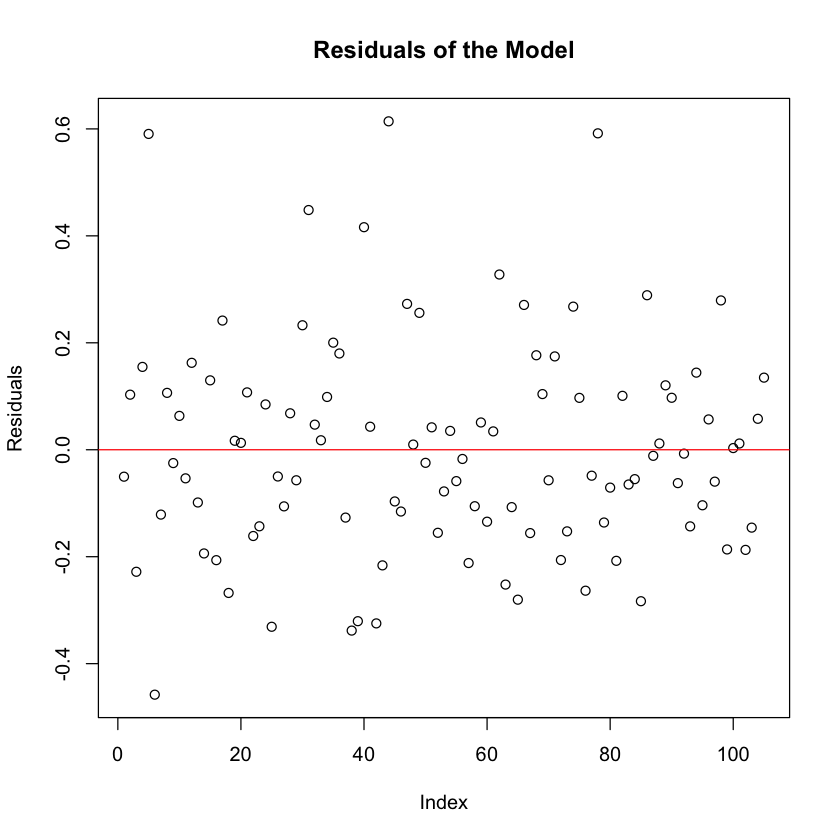

centering value unspecified. Automatically set to 25

centering value unspecified. Automatically set to 35

centering value unspecified. Automatically set to 40

centering value unspecified. Automatically set to 25



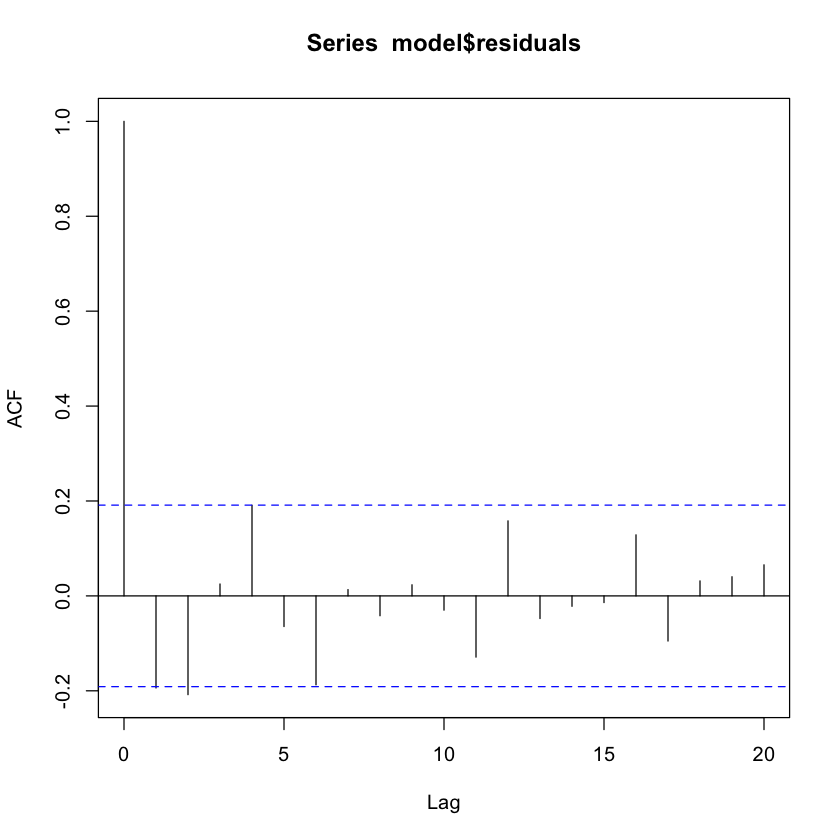

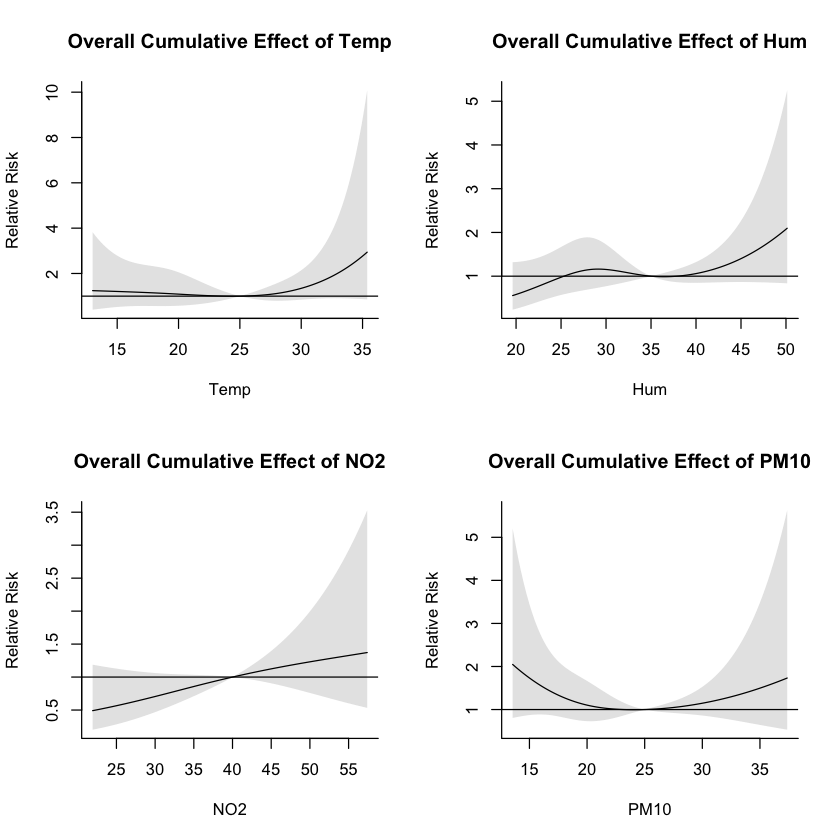

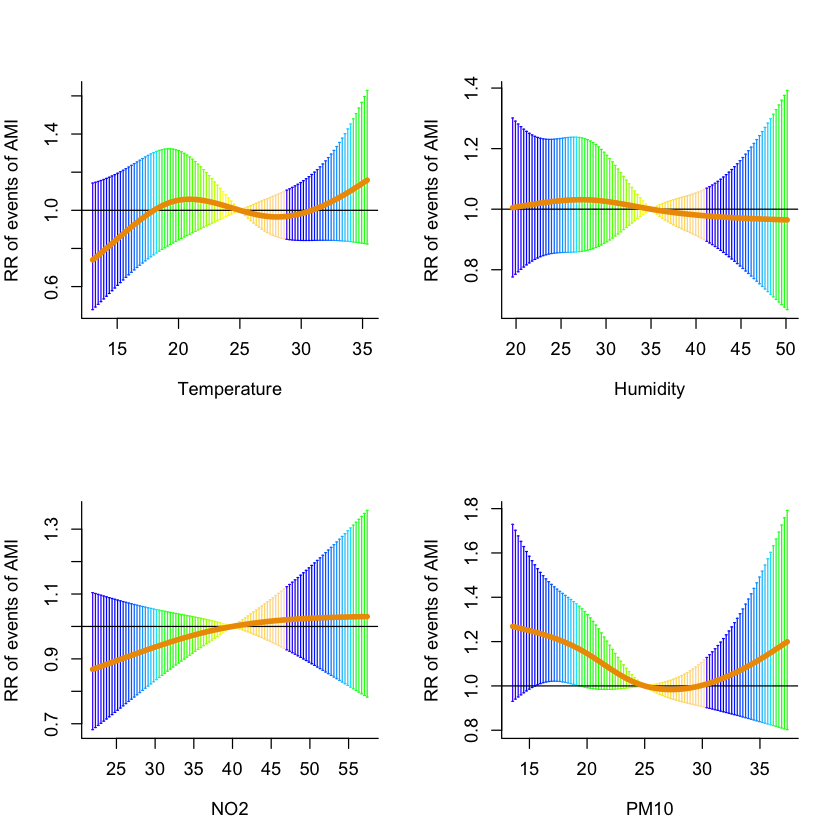

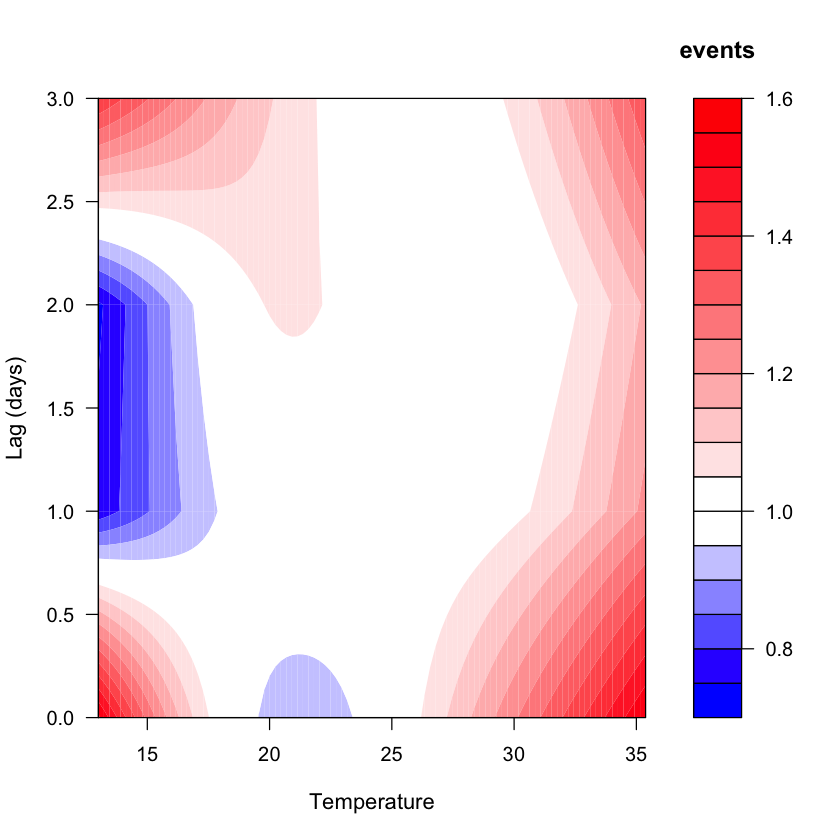

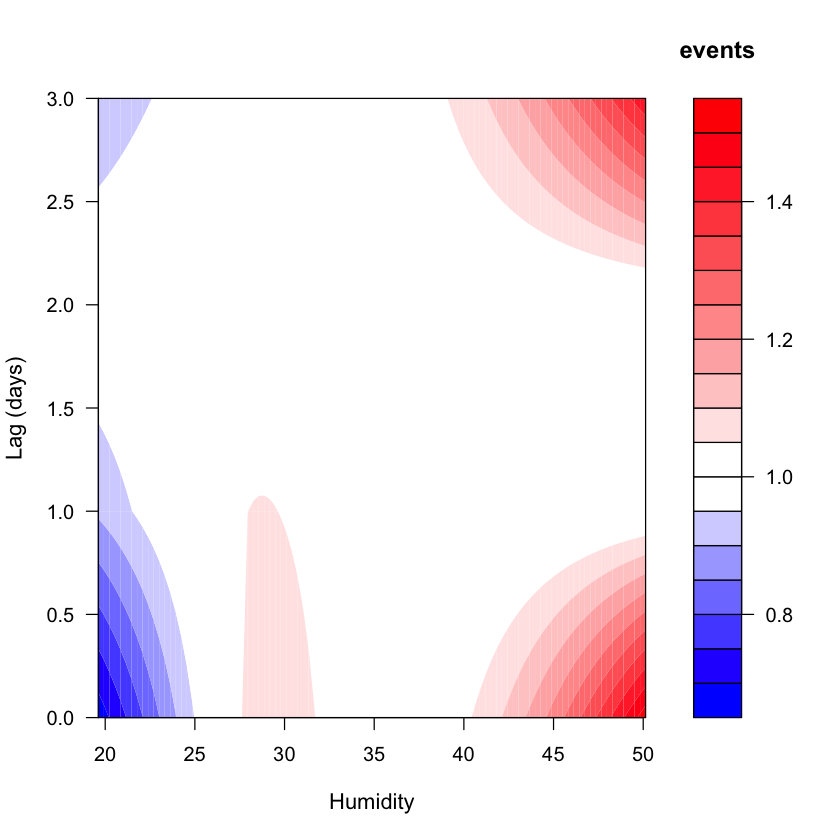

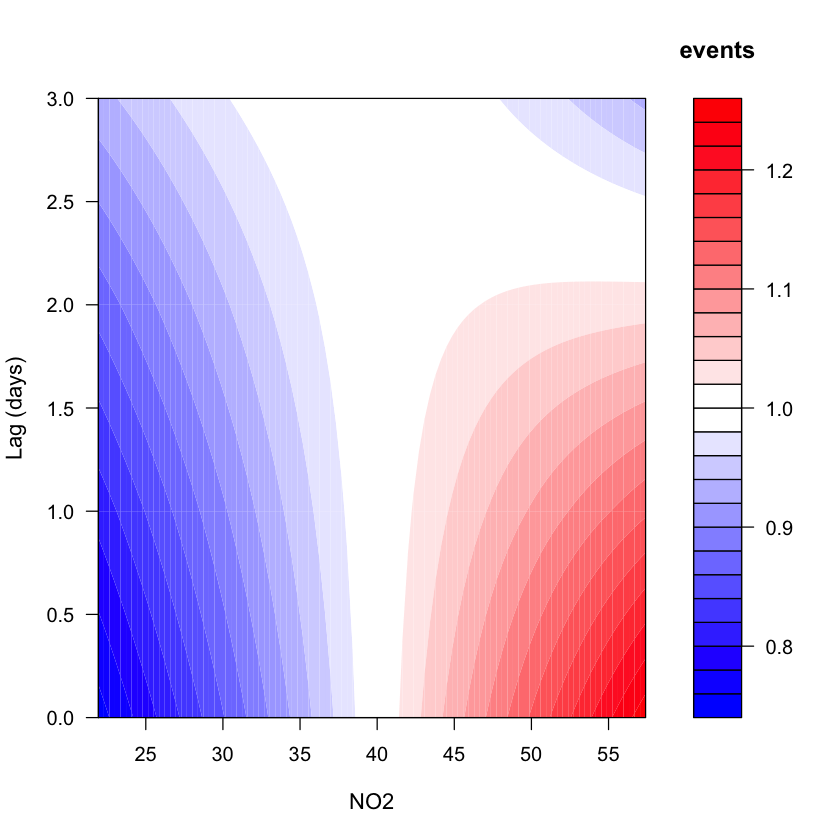

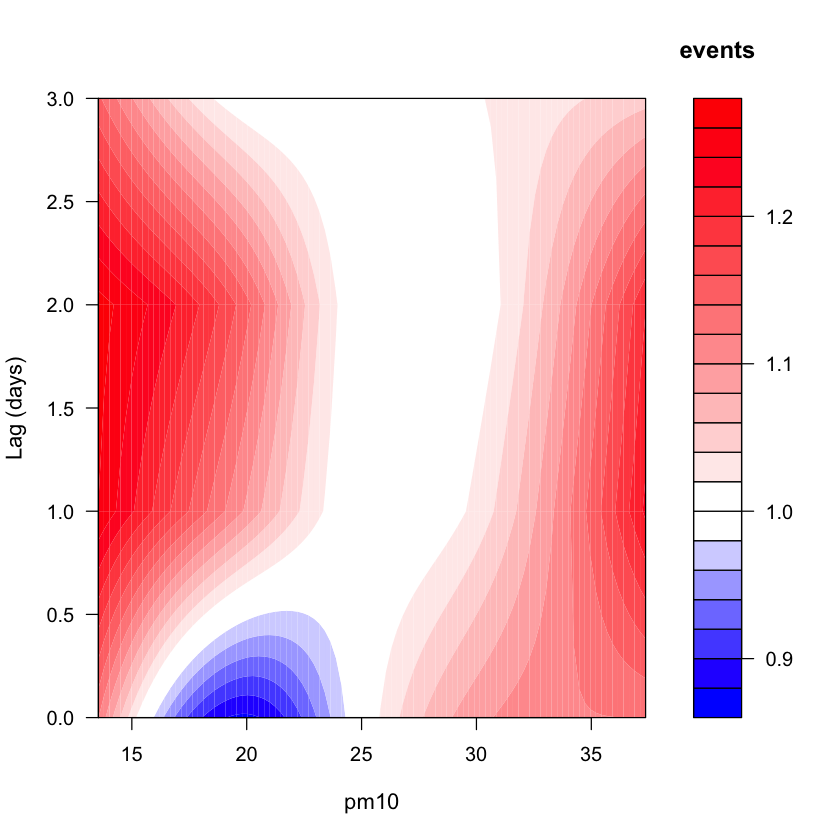

In [25]:
################################################################################
# READ DATA
################################################################################
data <- read.csv("modelling_data/monthly_data.csv")

################################################################################
# DATA VARIABLES SPLIT
################################################################################
# MIN
################################################################################
# data <- data %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = min_temp,
#                                 hum = min_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = min_PM10,
#                                 o3 = min_O3,
#                                 no2 = min_NO2,
#                                 so2 = min_SO2,
#                                 co = min_CO
#                                 )

# ################################################################################
# # MAX
# ################################################################################
# data <- data %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = max_temp,
#                                 hum = max_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = max_PM10,
#                                 o3 = max_O3,
#                                 no2 = max_NO2,
#                                 so2 = max_SO2,
#                                 co = max_CO
#                                 )

################################################################################
# MEAN
# ################################################################################
#  data <- data %>% dplyr:::mutate(
#     mean_temp = (max_temp + min_temp) / 2,
#     mean_hum = (max_hum + min_hum) / 2
#           ) %>% dplyr:::select(
#                                 at_code,
#                                 events,
#                                 temp = mean_temp,
#                                 hum = mean_hum,
#                                 is_holiday,
#                                 month,
#                                 year,
#                                 pm10 = mean_PM10,
#                                 o3 = mean_O3,
#                                 no2 = mean_NO2,
#                                 so2 = mean_SO2,
#                                 co = mean_CO
#                                 )

# ################################################################################
# # MIX
# ################################################################################
data <- data %>% dplyr:::select(
                                at_code,
                                events,
                                temp = max_temp,
                                hum = min_hum,
                                is_holiday,
                                month,
                                year,
                                pm10 = mean_PM10,
                                o3 = mean_O3,
                                no2 = mean_NO2,
                                so2 = mean_SO2,
                                co = mean_CO
                                )

#January, February, November, and December <– Paper 2019

# Function to categorize each month into a season
categorize_season <- function(month) {
  if (month %in% c(1, 2, 11, 12)) {
    return("Winter")
  } else {
    return("Summer")
  }
}

# Add a new column "season" to the environmeAMIet based on the month
data$season <- sapply(data$month, categorize_season)
# ################################################################################
# AT CODE
# ################################################################################
data = data[(data$at_code=="AT03"),]
#data$date <- as.Date(data$date)
# Simulate a date column based on month and year
#data$date <- as.Date(paste(data$year, data$month, "01", sep="-"))

# ################################################################################
# CROSS BASIS FUNCTIONS
# ################################################################################
# Create crossbasis for mean_PM10 and min_hum and ozone
cb_pm10 <- crossbasis(data$pm10, lag=3, 
                      argvar=list(fun="ns", df=3), 
                      arglag=list(fun="ns", df=3))

cb_hum <- crossbasis(data$hum, lag=3, 
                         argvar=list(fun="ns", df=3), 
                         arglag=list(fun="ns", df=3))

cb_no2 <- crossbasis(data$no2, lag=3, 
                         argvar=list(fun="ns", df=2), 
                         arglag=list(fun="ns", df=2))

cb_temp <- crossbasis(data$temp, lag=3, 
                    argvar=list(fun="ns", df=3), 
                    arglag=list(fun="ns", df=3))

cb_so2 <- crossbasis(data$so2, lag=3, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))

cb_co <- crossbasis(data$co, lag=3, 
                    argvar=list(fun="ns", df=2), 
                    arglag=list(fun="ns", df=2))
# ################################################################################
# MODEL FITTING
# ################################################################################
# Fit DLNM including min_hum
model <- glm(events ~ cb_pm10 + cb_hum + cb_no2 + cb_temp + ns(year, df=10), 
             data = data, family = quasipoisson)
# ################################################################################
# SUMMARY
# ################################################################################
# Summary of the model
summary(model)
# ################################################################################
# DIAGNOSTICS
# ################################################################################
plot(model$residuals, main="Residuals of the Model", ylab="Residuals", xlab="Index")
abline(h=0, col="red")

dispersion <- sum(residuals(model, type="pearson")^2) / model$df.residual
print(paste("Dispersion parameter:", dispersion))

#qqnorm(model$residuals)
#qqline(model$residuals, col="red")

acf(model$residuals)
# ################################################################################
# RESULTS
# ################################################################################
par(mfrow = c(2, 2))

# Create crosspred object for visualization of temp
pred_temp <- crosspred(cb_temp, model, at=seq(min(data$temp), max(data$temp), length=100))
# Plot overall cumulative effect
plot(pred_temp, "overall", xlab="Temp", ylab="Relative Risk", main="Overall Cumulative Effect of Temp")

# Create crosspred object for visualization of hum
pred_hum <- crosspred(cb_hum, model, at=seq(min(data$hum), max(data$hum), length=100))
# Plot overall cumulative effect
plot(pred_hum, "overall", xlab="Hum", ylab="Relative Risk", main="Overall Cumulative Effect of Hum")

# Create crosspred object for visualization of no2
pred_no2 <- crosspred(cb_no2, model, at=seq(min(data$no2), max(data$no2), length=100))
# Plot overall cumulative effect
plot(pred_no2, "overall", xlab="NO2", ylab="Relative Risk", main="Overall Cumulative Effect of NO2")

# Create crosspred object for visualization of pm10
pred_pm10 <- crosspred(cb_pm10, model, at=seq(min(data$pm10), max(data$pm10), length=100))
# Plot overall cumulative effect
plot(pred_pm10, "overall", xlab="PM10", ylab="Relative Risk", main="Overall Cumulative Effect of PM10")

# ################################################################################
# SLICES
# ################################################################################
par(mfrow = c(2, 2))
plot(pred_temp, "slices", xlab="Temperature", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_hum, "slices", xlab="Humidity", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_no2, "slices", xlab="NO2", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")
plot(pred_pm10, "slices", xlab="PM10", lag=c(2), col="orange2", ci.arg=list(col=topo.colors(70, alpha = 1)), ci.level=0.95, ci='b', lwd=4.5, ylab="RR of events of AMI", cex.lab=1.1, cex.axis=1.1,main="")

# ################################################################################
# CONTOURS
# ################################################################################
par(mfrow = c(1, 1))
# 3D, contour, and curve plots for temperature
#plot(pred_temp, xlab="Temperature", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_temp, "contour", key.title=title("events"), plot.title=title("", xlab ="Temperature", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for humidity
#plot(pred_hum, xlab="Humidity", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_hum, "contour", key.title=title("events"), plot.title=title("", xlab ="Humidity", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for no2
#plot(pred_no2, xlab="NO2", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_no2, "contour", key.title=title("events"), plot.title=title("", xlab ="NO2", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))

# 3D, contour, and curve plots for pm10
#plot(pred_pm10, xlab="PM10", ylab="Lag (days)", zlab="RR of events of AMI", theta=150, phi=5, lphi=100, cex.lab=1.1, cex.axis=1.1, col="gray80",main="")
plot(pred_pm10, "contour", key.title=title("events"), plot.title=title("", xlab ="pm10", ylab = "Lag (days)", cex.lab=1.1, cex.axis=1.1))


